$$red (x,y) = [u(x,y);v(x,y)]$$
$$f''(x,y)=-f(x,y)$$

$$u(x,y)=e^{-2x-y}$$
$$ \frac{du}{dx} = -2*u(x,y)$$
$$ \frac{du}{dy} = -u(x,y)$$
$$v(x,y)=e^{-x-2y}$$
$$ \frac{dv}{dx} = -v(x,y)$$
$$ \frac{dv}{dy} = -2v(x,y)$$
$$ red(0,0) = 1,1 $$


## Pre procesamiento
### Se importan librerias, se define la geometria, la arquitectura de la red y el dispositivo de procesamiento

In [1]:
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
device = "cuda"

uprom = 2
rho = 0.001
mu = 10

class NeuralNetworkPrueba(nn.Module):
    def __init__(self):
        super(NeuralNetworkPrueba, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 50),
            nn.Tanh(),
            nn.Linear(50, 3)
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits


red=NeuralNetworkPrueba().to(device)


### Se definen las condiciones de frontera y se pre entrena la red para evitar que el gradiente acerque la red a la solución trivial

In [2]:
n_vec = 64
x = torch.linspace(-1*0,1,n_vec, device = device)
y = torch.linspace(-1*0,1,n_vec, device = device)
vec0 = torch.linspace(0,0,n_vec, device = device)
vec1 = torch.linspace(1,1,n_vec, device = device)
puntosInlet = torch.t(torch.vstack((vec0,y)))

class u_ini_clase(torch.autograd.Function):
	#Esta clase corresponde al perfil de entrada
	@staticmethod
	def forward(ctx, input):
		ctx.save_for_backward(input)
		k=-8*uprom/(1)**2
		return k * (input)*(input-1)
	
	@staticmethod
	def backward(ctx, grad_output):
		input, = ctx.saved_tensors
		k=-8*uprom/(1)**2
		return grad_output * k * (2 * input - 1)
u_ini_2=u_ini_clase.apply


def perdidaCFinlet():
    u_inlet_temp = u_ini_2 (puntosInlet[:,1])
    suma = 0
    vecobj = torch.t(torch.vstack((u_inlet_temp,vec0,vec0))) 
    for i in range(len(u_inlet_temp)):
        suma+=(vecobj[i]-red(puntosInlet[i])).norm()
    return suma
    
perdidaCFinlet()

tensor(163.8646, device='cuda:0', grad_fn=<AddBackward0>)

### Se definen las condiciones de frontera

In [3]:
learning_rate = 1e-4
epochs = 4000
optimizer = torch.optim.Adam(red.parameters(), lr=learning_rate)
registro_perdida=[]
for i in range(epochs):
    # Compute prediction and loss
    loss = perdidaCFinlet()
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(loss.item())
    registro_perdida.append(loss.item())

163.8646240234375
98.22774505615234
65.40205383300781
65.0201416015625
64.51107025146484
62.72126770019531
54.452232360839844
44.6255989074707
43.528865814208984
40.92667770385742
30.98751449584961
11.159796714782715
7.385897636413574
6.3649749755859375
5.594737529754639
4.7349467277526855
3.64031982421875


KeyboardInterrupt: 

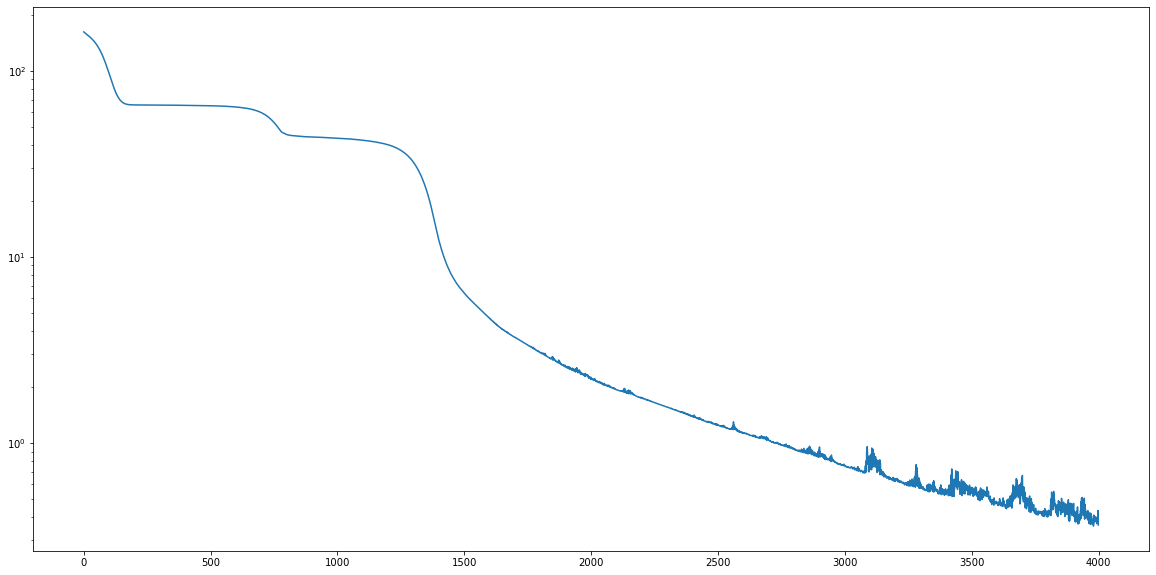

In [ ]:
torch.save(red.state_dict,"intento1NS.txt")
plt.figure(figsize = (20,10))
plt.semilogy(registro_perdida)

Los puntos deben parar cuando el gradiente llegue a un punto cercano a acero. este punto cercano a o puede ser un 100 avo del valor de lectura original del gradiente o cuando salgan del dominio. 

$$y'' = -y$$
$$y(0) = 0$$

Text(0.5, 1.0, 'Variando a traves de x')

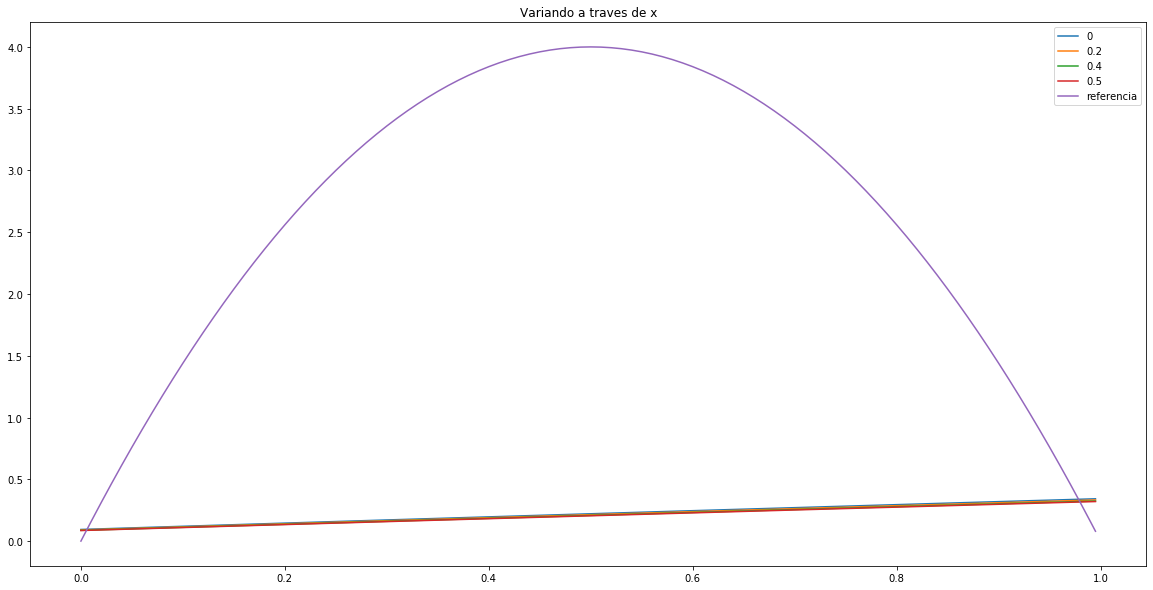

In [ ]:
import numpy as np
red.load_state_dict(torch.load("NS 1400.tar"))
x_grafComp = np.linspace(0,1,50)
plt.figure(figsize = (20,10))
for j in [0,0.2,0.4,0.5]:
    yGrafica = []
    uGrafica = [] 
    uRef = []
    for i in range(200):
        y_loc = i/200
        utemp=red(torch.tensor([j,y_loc],device = device))
        ureftemp = u_ini_2(y_loc)
        #ygrafica.append(ytemp.cpu().detach().numpy()[0])
        uGrafica.append(utemp.cpu().detach().numpy()[0])
        uRef.append(ureftemp)
        yGrafica.append(y_loc)
    yGrafica = np.array(yGrafica)
    #plt.plot(np.array(xGrafica),5.1*np.exp(-2*xGrafica-j),label = str(j)+ "ref")
    plt.plot(yGrafica,uGrafica,label=j)
plt.plot(yGrafica,uRef,label="referencia")
plt.legend()
plt.title("Variando a traves de x")

### Definición de la función de perdida para el entrenamiento de la red

To do
- Paralelizar
    - usar torch.jit
    - partir el navier stokes en varios navier stokes chiquitos que se hacen en diferentes jit
        - Evaluar si se puede definir de forma dinamica cuantos jit se hacen
        

In [ ]:
puntos=torch.cartesian_prod(x,y)
puntos.requires_grad = True
        
puntosPared = torch.t(torch.hstack((torch.vstack((x,vec0)),torch.vstack((x,vec1)))))
puntosPared.requires_grad = True

puntosOutlet = torch.t(torch.vstack((vec1,y)))
puntosOutlet.requires_grad = True

def perdida():
    global rho, mu
    suma = 0
    for i in puntos:
        u = red(i)[0]
        v = red(i)[1]
        p = red(i)[2]
        dpdx=torch.autograd.grad(p,i,create_graph=True)[0][0]
        dpdy=torch.autograd.grad(p,i,create_graph=True)[0][1]
        dudx=torch.autograd.grad(u,i,create_graph=True)[0][0]
        dudy=torch.autograd.grad(u,i,create_graph=True)[0][1]
        dvdx=torch.autograd.grad(v,i,create_graph=True)[0][0]
        dvdy=torch.autograd.grad(v,i,create_graph=True)[0][1]
        dduddx = torch.autograd.grad(dudx,i,create_graph=True)[0][0]
        dduddy = torch.autograd.grad(dudy,i,create_graph=True)[0][1]
        ddvddx = torch.autograd.grad(dvdx,i,create_graph=True)[0][0]
        ddvddy = torch.autograd.grad(dvdy,i,create_graph=True)[0][1]
        
        suma+=(rho*(u*dudx+v*dudy)+dpdx-(dduddx+dduddy)*mu)**2
        suma+=(rho*(u*dvdx+v*dvdy)+dpdy-(ddvddx+ddvddy)*mu)**2
        suma+=(dudx+dvdy)**2
        
    
    #Puntos en la pared
    for i in puntosPared:
        u = red(i)[0]
        v = red(i)[1]
        suma+=1*(u**2+v**2)

    #Puntos en la entrada
    suma += 1*perdidaCFinlet()
    #Puntos Outlet
    for i in puntosOutlet:
        p = red(i)[2]
        suma += p**2

    return suma
perdida()

tensor(322.6407, device='cuda:0', grad_fn=<AddBackward0>)

In [73]:
learning_rate = 1e-4
epochs = 4000
optimizer = torch.optim.Adam(red.parameters(), lr=learning_rate)
registro_perdida=[]
for i in range(epochs):
    # Compute prediction and loss
    loss = perdidaCFinlet()
    
    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % 100 == 0:
        print(loss.item())
    registro_perdida.append(loss.item())

torch.save(red.state_dict,"intento1NS terminado.tar")

TypeError: linear(): argument 'input' (position 1) must be Tensor, not list